# 用AtuoEncoder做一些有趣的事情

有人甚至做了Mask AutoEncoder之类的东西，第一次知道可以这样去恢复原数据，真的非常有意思。可以在这里也试一下AutoEncoder，下面用了mnist俩个数据集（一个最经典的、一个FashionMnist,只需要切换一下datasets那里的数据运行便可以看到效果）。

- 本笔记特意投影到三维的区间方便用三维空间画出十种数据在autoEncoder降维之后十如何分布的，我们通过三维图看到相同的数据还是分布在一块，也就是说明了降维成功了。而且这些数据也能很好的刻画原数据的值（最后的测试集可以看到效果）。

- 最后利用测试集的数据进行随机的图片生成，这里的应用我们可能以后会想到token的应用，提取关键词，用decoder生成图片（对应之后的diffusion模型）

### 加入库

In [63]:
# Import PyTorch modules
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [64]:
# 打印torch和torchvision的版本
import torchvision
print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [65]:
!nvidia-smi

Wed Feb 22 15:32:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    31W /  70W |    858MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### 定义超参数

In [66]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [67]:
# Define hyperparameters
batch_size = 100
num_epochs = 20
learning_rate = 0.001

### 加载数据集

In [71]:
# Load MNIST dataset
# train_dataset = datasets.MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)
train_dataset = datasets.FashionMNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.FashionMNIST(root='data/', train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [72]:
print(train_dataset.data.shape)
print(test_dataset.data.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])


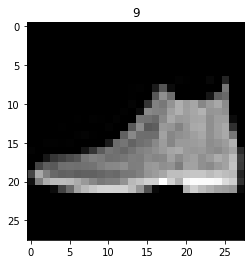

In [73]:
# 用plt显示一张图片
import matplotlib.pyplot as plt
plt.imshow(test_dataset.data[0].numpy(), cmap='gray')
plt.title('%i' % test_dataset.targets[0])
plt.show()

### 展示图像

In [74]:
# Import matplotlib.pyplot module for plotting images
import matplotlib.pyplot as plt

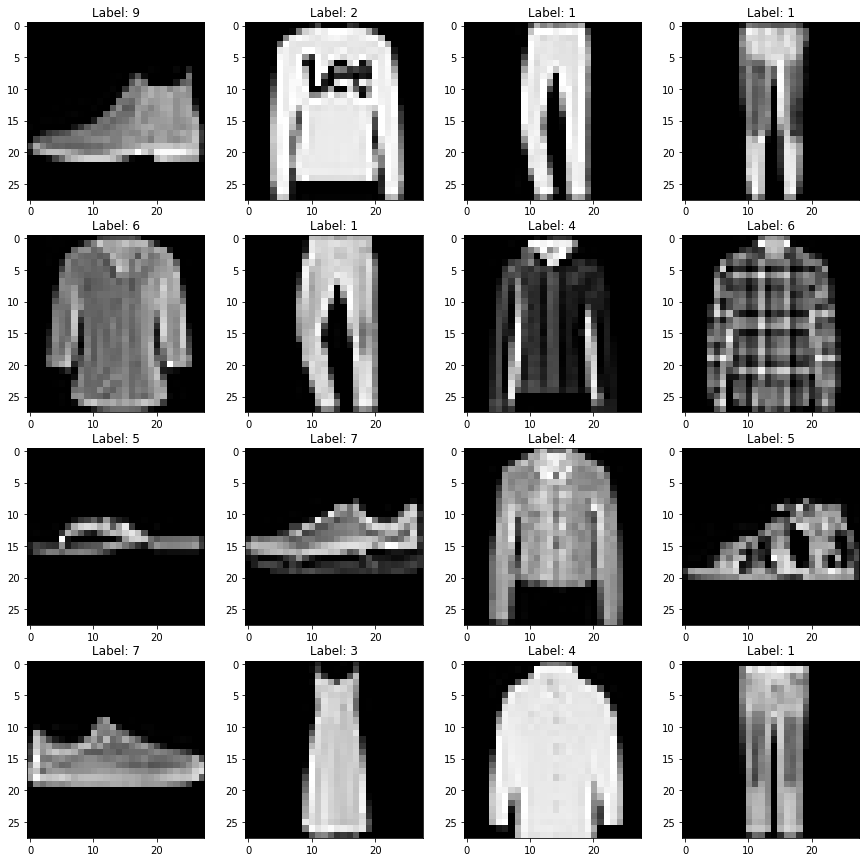

In [75]:
# Plot some sample images from test dataset 
for data in test_loader:
    # Get input images and labels 
    img,label  = data 
    img = img.to(device) 
    label = label.to(device)

    # Plot a grid of 16 images with their labels 
    fig ,axs = plt.subplots(4 ,4 ,figsize=(15 ,15)) 
    for i in range(4): 
        for j in range(4): 
            # Get image tensor at index i*4+j index i*4+j image img[index]
            index = i*4+j
            image = img[index]
            # Convert image tensor to numpy array and transpose it to HxWxC format 
            image = image.cpu().numpy().transpose(1 ,2 ,0)

            # Plot image on subplot 
            axs[i][j].imshow(image.squeeze() ,cmap='gray') 
            axs[i][j].set_title(f'Label: {label[index].item()}')
    # Show the figure 
    plt.show()
    # Break after one batch 
    break

### 定义网络

In [76]:
# Define autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3) # Latent space representation
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid() # To get values between 0 and 1 for pixel values
        )

    def forward(self, x):
        # Encode input to latent space representation
        encoded = self.encoder(x)
        # Decode latent space representation to reconstructed output
        decoded = self.decoder(encoded)
        return decoded

# Define convolutional autoencoder model
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1), # (N, 1, 28, 28) -> (N, 16, 14 ,14)
            nn.ReLU(),
            nn.Conv2d(16 ,32 ,3 ,stride=2 ,padding=1), # (N ,16 ,14 ,14) -> (N ,32 ,7 ,7)
            nn.ReLU(),
            nn.Conv2d(32 ,64 ,7), # (N ,32 ,7 ,7) -> (N ,64 ,1 ,1)
        )
        # Decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64 ,32 ,7), # (N ,64 ,1 ,1) -> (N ,32 ,7 ,7)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3,stride=2,padding=1,output_padding=1), # (N .32 .7 .7) -> (N .16 .14 .14)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3,stride=2,padding=1,output_padding=1), # (N .16 .14 .14) -> (N .1 .28 .28)
            nn.Sigmoid() # To get values between 0 and 1 for pixel values 
        )

    def forward(self,x):
        # Encode input to latent space representation 
        encoded = self.encoder(x) 
        # Decode latent space representation to reconstructed output 
        decoded = self.decoder(encoded) 
        return decoded

### 模型定义

In [77]:
# Create model instance and move it to device (GPU or CPU)
model = Autoencoder()
# model = ConvAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# Define loss function and optimizer
criterion = nn.MSELoss(reduction = 'none') # Mean Squared Error loss for reconstruction error 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


### 开始训练并评估

In [78]:
print(len(train_loader.dataset))
print(len(test_loader.dataset))

60000
10000


In [79]:
train_loss_list = [] # To store training loss for each epoch
test_loss_list = [] # To store test loss for each epoch
# Training loop 
for epoch in range(num_epochs):
    train_loss = 0
    test_loss = 0
    train_example_num = 0
    test_example_num = 0

    # =================== Testing ===================
    model.eval() # Set model to evaluation mode
    with torch.no_grad(): # Disable gradient calculation
        for data in test_loader:
            # Get input images and flatten them to vectors of size 784 (28*28)
            img, _ = data 
            img = img.view(img.size(0), -1) 
            img = img.to(device) 

            # Forward pass to get reconstructed output 
            output = model(img) 

            # Compute reconstruction loss 
            loss = criterion(output, img) 
            loss = loss.mean()

            test_loss += loss.item() * img.size(0)
            test_example_num += img.size(0)

    
    # =================== Training ===================
    model.train() # Set model to training mode
    for data in train_loader:
        # Get input images and flatten them to vectors of size 784 (28*28)
        img, _ = data 
        img = img.to(device) 
        img = img.view(img.size(0), -1) 
        

        # Forward pass to get reconstructed output 
        output = model(img) 

        # Compute reconstruction loss 
        loss = criterion(output, img) 
        loss = loss.mean()

        # Backward pass and update parameters 
        optimizer.zero_grad() 
        loss.backward() 
        optimizer.step() 

        train_loss += loss.item() * img.size(0)
        train_example_num += img.size(0)

    
    # =================== Logging ===================
    # Save training loss
    train_loss_list.append(train_loss/60000) # train_loader.dataset is the entire dataset
    # Save test loss 
    test_loss_list.append(test_loss/10000) # test_loader.dataset is the entire dataset

    # Print training and test loss for each epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_list[-1]:.4f}, Test Loss: {test_loss_list[-1]:.4f}")


Epoch 1/20, Train Loss: 0.0505, Test Loss: 0.1701
Epoch 2/20, Train Loss: 0.0339, Test Loss: 0.0364
Epoch 3/20, Train Loss: 0.0282, Test Loss: 0.0302
Epoch 4/20, Train Loss: 0.0264, Test Loss: 0.0269
Epoch 5/20, Train Loss: 0.0256, Test Loss: 0.0260
Epoch 6/20, Train Loss: 0.0252, Test Loss: 0.0255
Epoch 7/20, Train Loss: 0.0248, Test Loss: 0.0250
Epoch 8/20, Train Loss: 0.0244, Test Loss: 0.0249
Epoch 9/20, Train Loss: 0.0241, Test Loss: 0.0244
Epoch 10/20, Train Loss: 0.0238, Test Loss: 0.0242
Epoch 11/20, Train Loss: 0.0235, Test Loss: 0.0237
Epoch 12/20, Train Loss: 0.0232, Test Loss: 0.0235
Epoch 13/20, Train Loss: 0.0230, Test Loss: 0.0236
Epoch 14/20, Train Loss: 0.0228, Test Loss: 0.0231
Epoch 15/20, Train Loss: 0.0227, Test Loss: 0.0230
Epoch 16/20, Train Loss: 0.0225, Test Loss: 0.0230
Epoch 17/20, Train Loss: 0.0224, Test Loss: 0.0226
Epoch 18/20, Train Loss: 0.0223, Test Loss: 0.0226
Epoch 19/20, Train Loss: 0.0222, Test Loss: 0.0225
Epoch 20/20, Train Loss: 0.0221, Test Lo

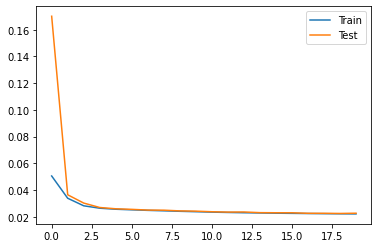

In [80]:
# Plot training and test loss
plt.plot(train_loss_list, label="Train")
plt.plot(test_loss_list, label="Test")
plt.legend()
plt.show()

### 看一下encoder的结果

In [16]:
data_tmp = test_dataset.data[0].view(-1)

In [17]:
data_tmp.shape

torch.Size([784])

In [18]:
data_tmp.dtype

torch.uint8

In [19]:
data_tmp = data_tmp.float().to(device)

In [20]:
test_dataset.data.view(10000,-1).shape

torch.Size([10000, 784])

In [21]:
with torch.no_grad():
  output = model.encoder(data_tmp)
output

tensor([-1947.6212,   793.4739,  1010.8380], device='cuda:0')

In [81]:
# 得到encoded 测试集
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    # Get input images and flatten them to vectors of size 784 (28*28)
    img = test_dataset.data
    img = img.view(10000,-1) 
    img = img.float().to(device) 

    # Forward pass to get reconstructed output 
    output = model.encoder(img) 
    test_encoded = output.cpu().numpy()


In [82]:
test_encoded.shape

(10000, 3)

In [83]:
test_encoded[0]

array([-440.385  ,  887.1012 ,  338.86945], dtype=float32)

### 画出三维图

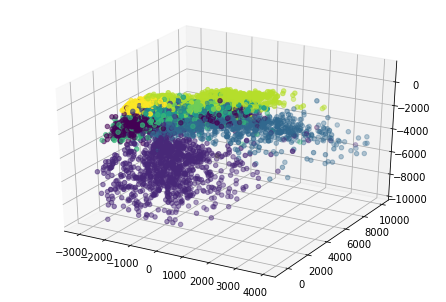

In [142]:
# 用Axes3D画3d图
from mpl_toolkits.mplot3d import Axes3D

# 画3d图，标签为test_dataset.targets
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(test_encoded[:,0], test_encoded[:,1], test_encoded[:,2], c=test_dataset.targets)
plt.show()

### 保存数据

In [84]:
import numpy as np
import matplotlib.pyplot as plt
# 保存 test_encoded 为 test_encoded.csv
np.savetxt('test_encoded_fashionMnist.csv', test_encoded, delimiter = ',')

# 保存 test_dataset.targets 为 test_dataset_targets.csv
np.savetxt('test_dataset_targets_fashionMnist.csv', test_dataset.targets, delimiter = ',')

### 查看测试集效果

In [85]:
test_encoded[3]

array([ -652.92444,  1792.8131 , -4744.6997 ], dtype=float32)

In [86]:
mean = test_encoded.mean(axis=0)
std = test_encoded.std(axis=0)
print("mean", mean)
print("std", std)

mean [ -711.3988  2512.099  -1240.0192]
std [ 979.6909 1675.2717 1836.2504]


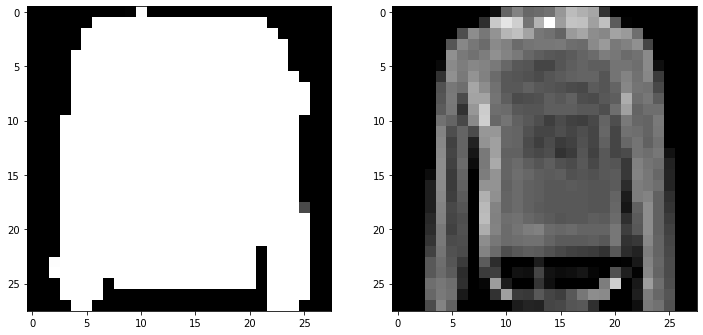

In [124]:
# rand_np = np.random.rand(1,3)*std + mean
idx = 16
rand_np = test_encoded[idx]
tensor = torch.from_numpy(rand_np).float().to(device)

# 得到encoded 测试集
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    # Forward pass to get reconstructed output 
    img = model.decoder(tensor) 
    img_np = img.cpu().numpy()

plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.subplot(1,2,2)
plt.imshow(test_dataset.data[idx], cmap='gray')
plt.show()

### 生成随机图片

In [143]:
rand_np = np.random.rand(1,3)*std + mean
print(rand_np)

[[  75.45228515 3474.15970238 -136.45733898]]


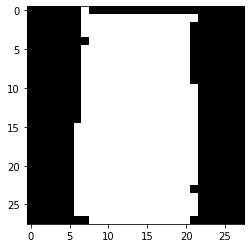

In [141]:
tensor = torch.from_numpy(rand_np).float().to(device)

# 得到encoded 测试集
model.eval() # Set model to evaluation mode
with torch.no_grad(): # Disable gradient calculation
    # Forward pass to get reconstructed output 
    img = model.decoder(tensor) 
    img_np = img.cpu().numpy()

plt.figure()
plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()

### 看单独维度线性改变对生成图像影响

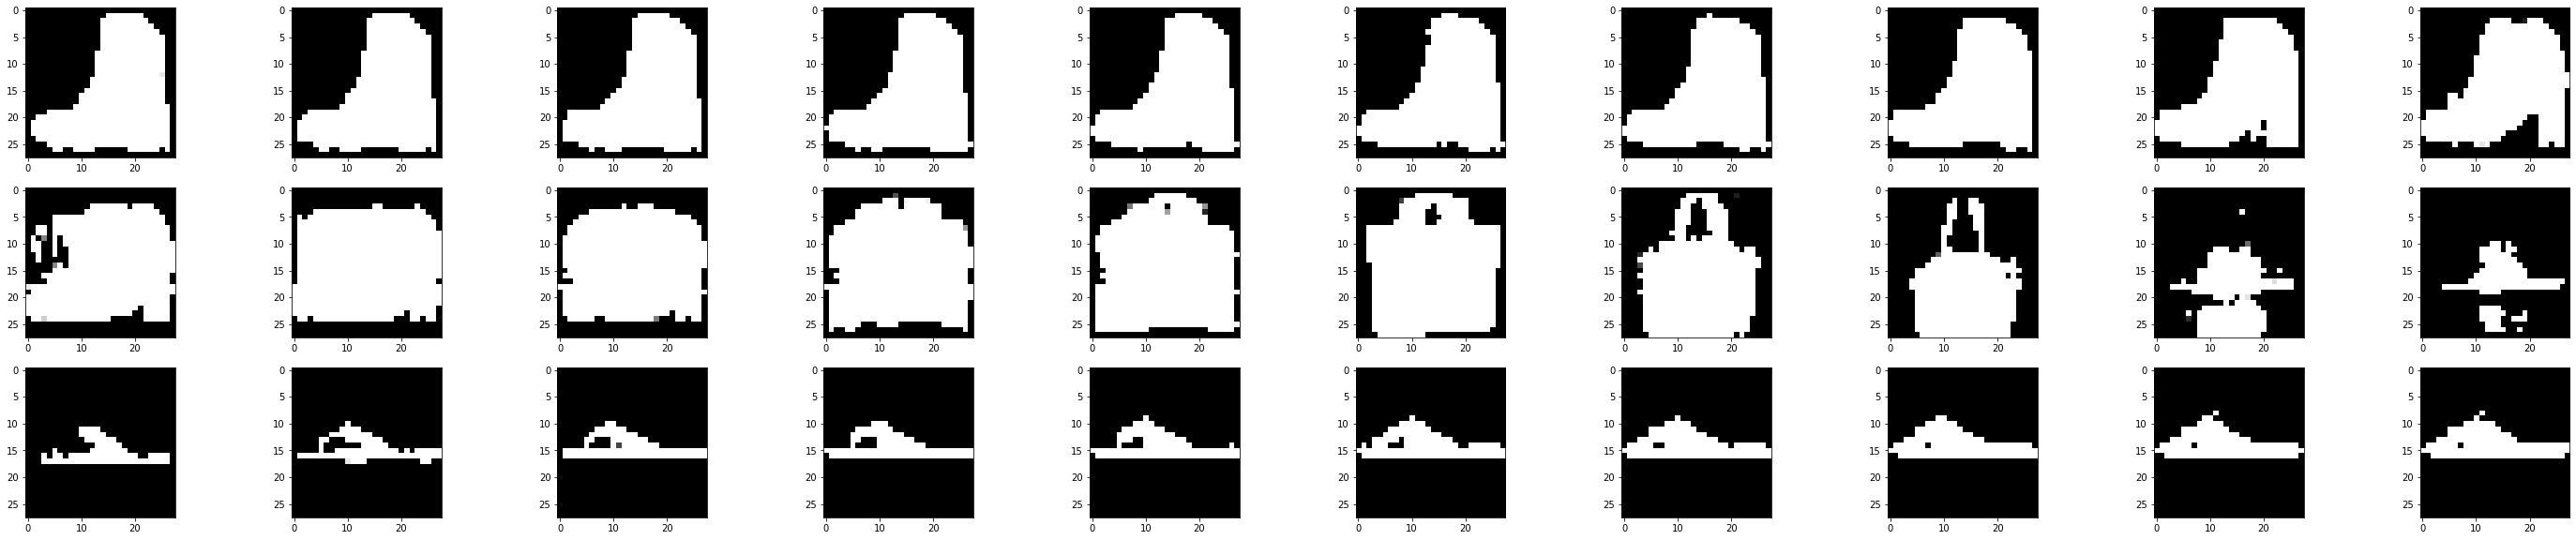

In [175]:
mask = np.array([1,0,0])
plt.figure(figsize=(50,10))
for i in range(30):
  tmp = rand_np + mask * (i - 15) * 500
  tensor = torch.from_numpy(tmp).float().to(device)
  # 得到encoded 测试集
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
      # Forward pass to get reconstructed output 
      img = model.decoder(tensor) 
      img_np = img.cpu().numpy()
  plt.subplot(3,10,i+1)
  plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()

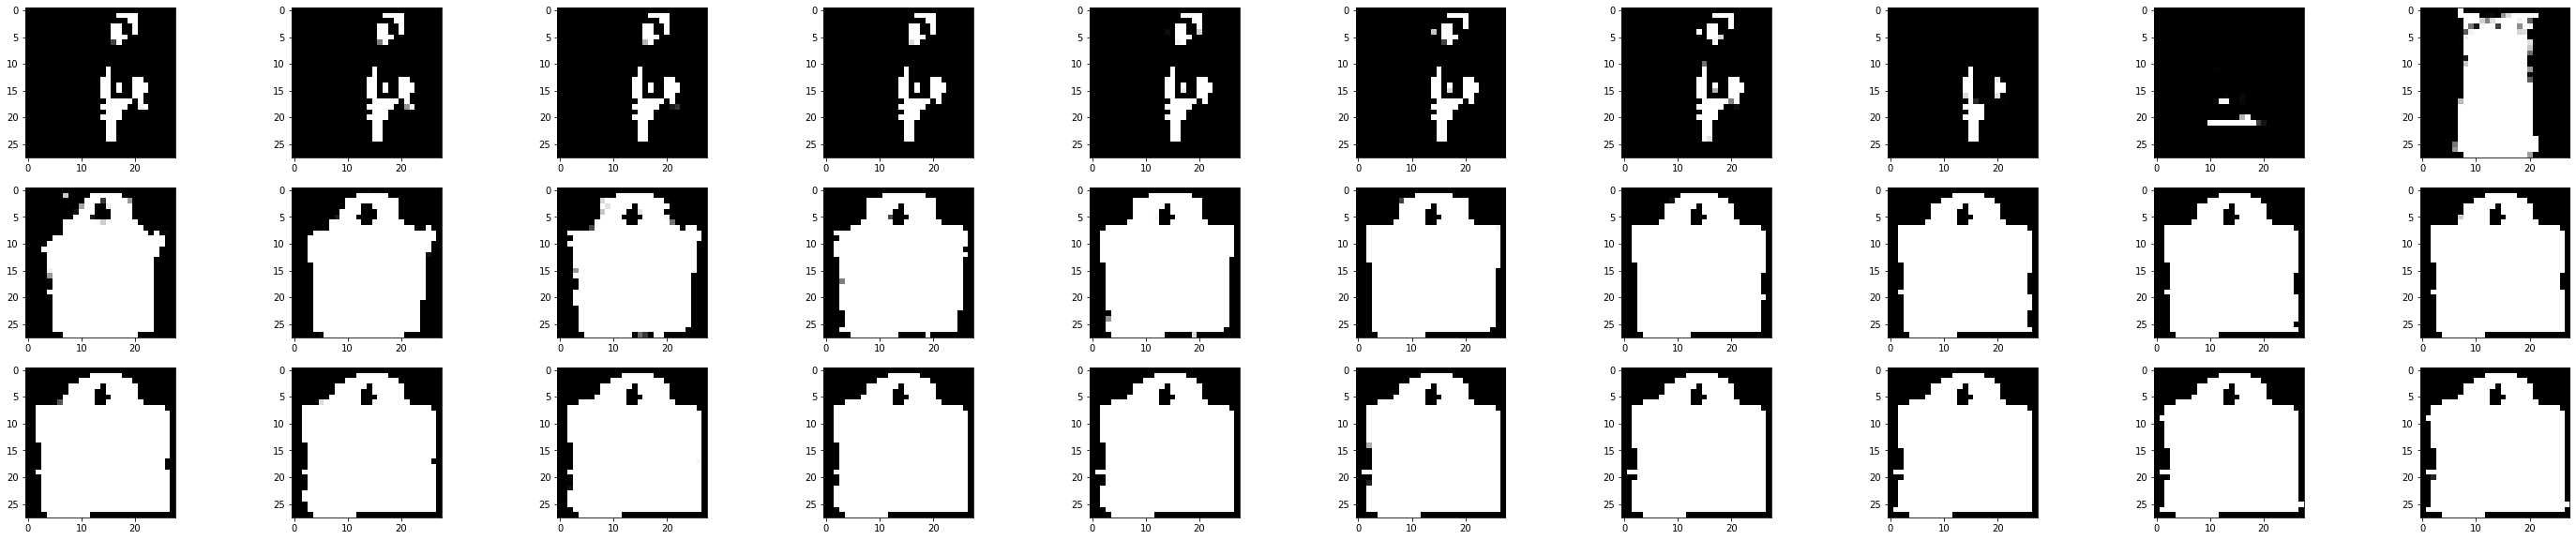

In [176]:
mask = np.array([0,1,0])
plt.figure(figsize=(50,10))
for i in range(30):
  tmp = rand_np + mask * (i - 15) * 500
  tensor = torch.from_numpy(tmp).float().to(device)
  # 得到encoded 测试集
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
      # Forward pass to get reconstructed output 
      img = model.decoder(tensor) 
      img_np = img.cpu().numpy()
  plt.subplot(3,10,i+1)
  plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()

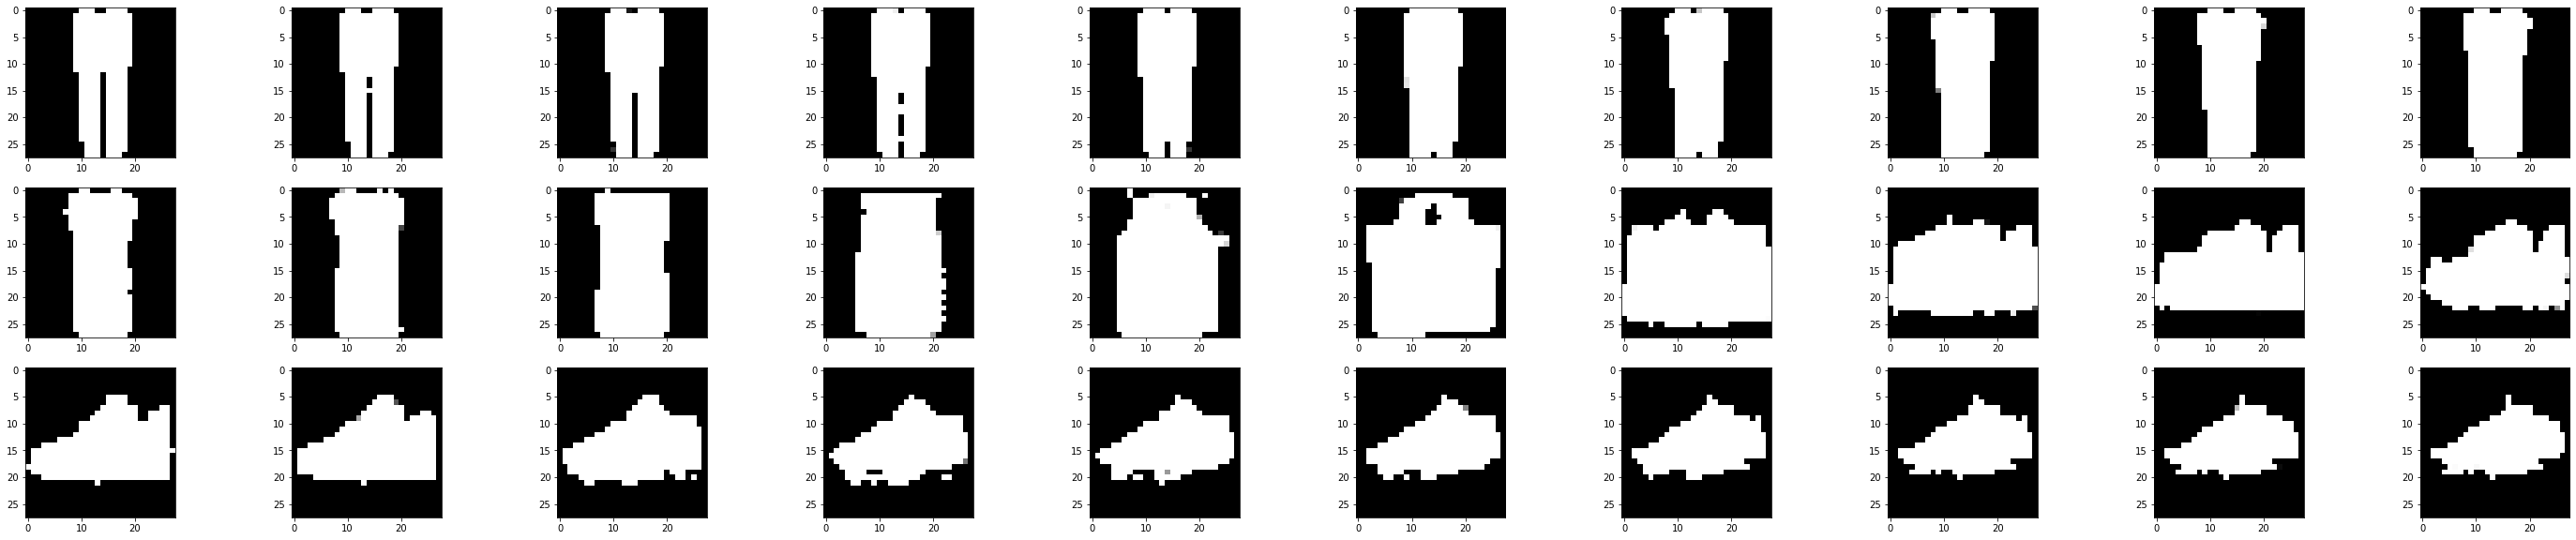

In [177]:
mask = np.array([0,0,1])
plt.figure(figsize=(50,10))
for i in range(30):
  tmp = rand_np + mask * (i - 15) * 500
  tensor = torch.from_numpy(tmp).float().to(device)
  # 得到encoded 测试集
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
      # Forward pass to get reconstructed output 
      img = model.decoder(tensor) 
      img_np = img.cpu().numpy()
  plt.subplot(3,10,i+1)
  plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()

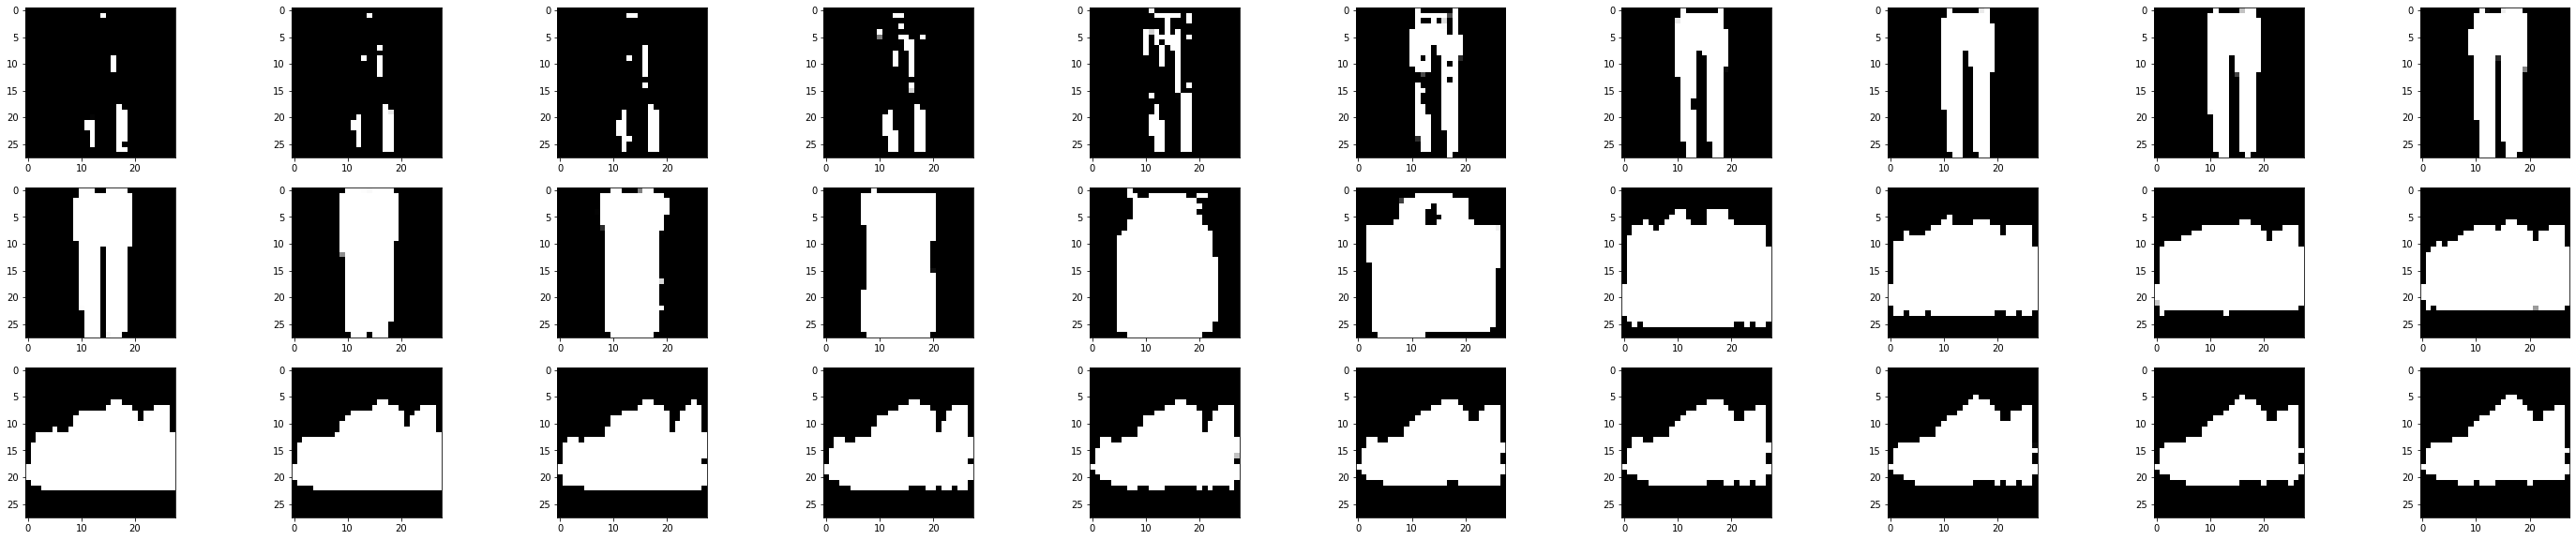

In [178]:
mask = np.array([0,1,1])
plt.figure(figsize=(50,10))
for i in range(30):
  tmp = rand_np + mask * (i - 15) * 500
  tensor = torch.from_numpy(tmp).float().to(device)
  # 得到encoded 测试集
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
      # Forward pass to get reconstructed output 
      img = model.decoder(tensor) 
      img_np = img.cpu().numpy()
  plt.subplot(3,10,i+1)
  plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()

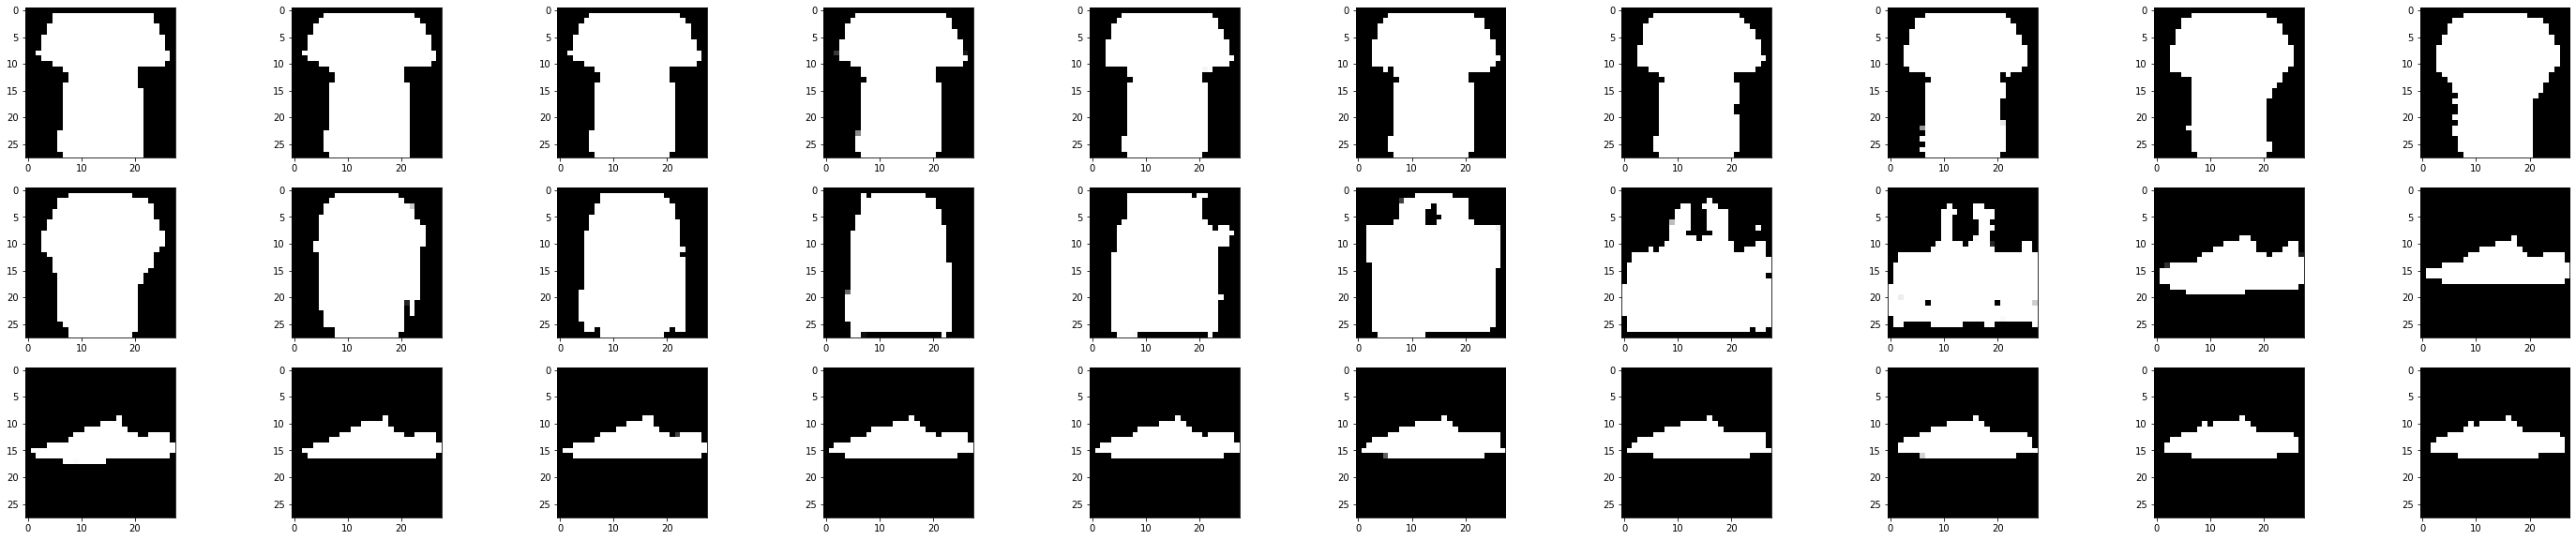

In [179]:
mask = np.array([1,0,1])
plt.figure(figsize=(50,10))
for i in range(30):
  tmp = rand_np + mask * (i - 15) * 500
  tensor = torch.from_numpy(tmp).float().to(device)
  # 得到encoded 测试集
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
      # Forward pass to get reconstructed output 
      img = model.decoder(tensor) 
      img_np = img.cpu().numpy()
  plt.subplot(3,10,i+1)
  plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()

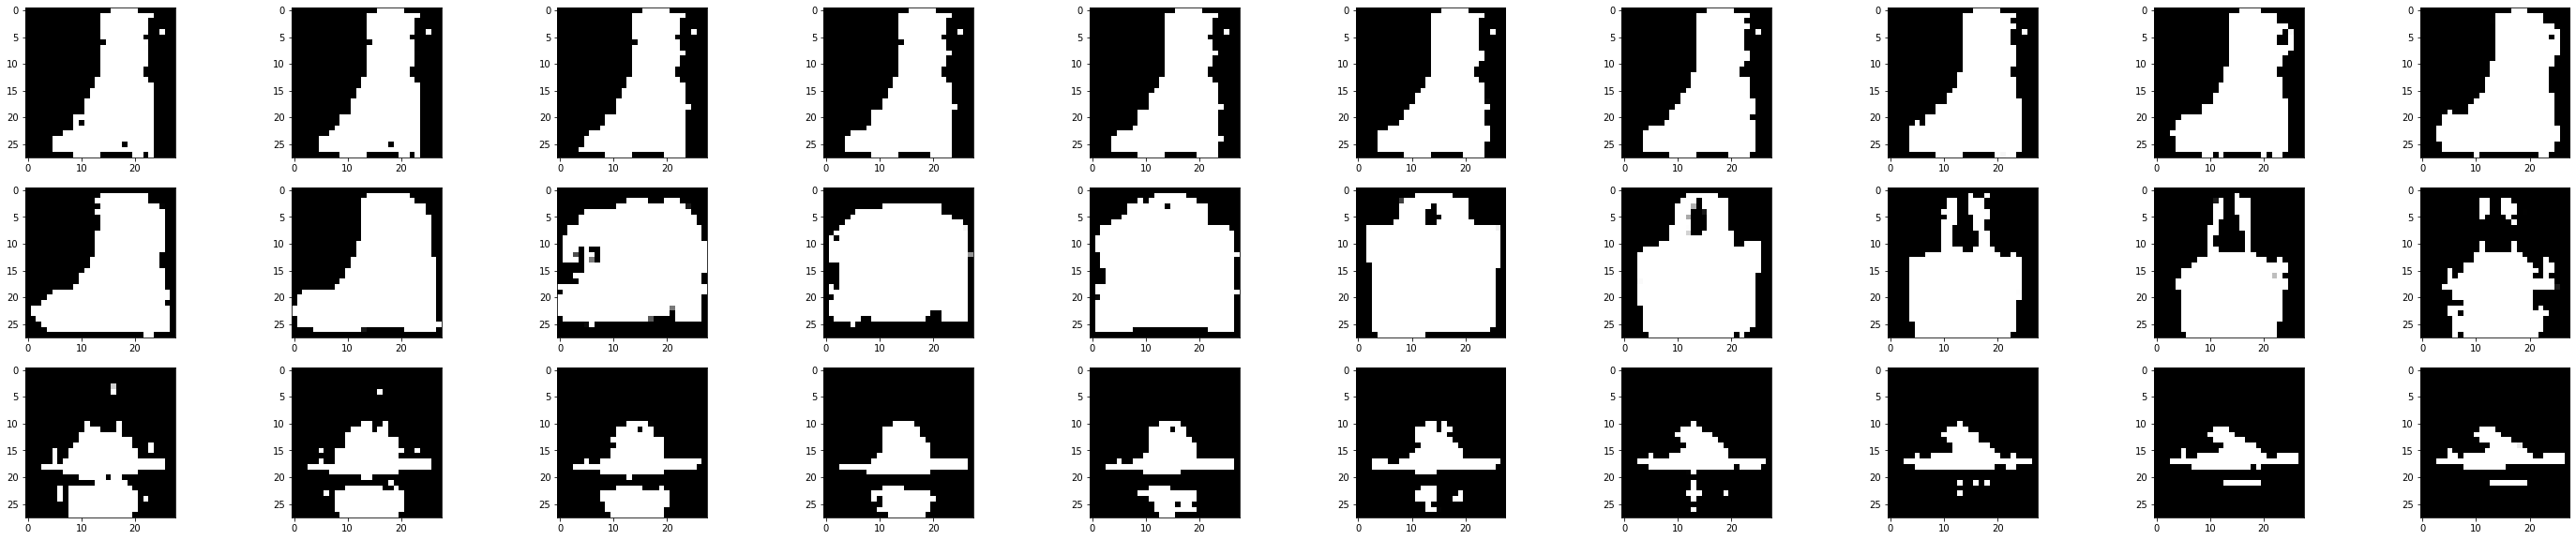

In [180]:
mask = np.array([1,1,0])
plt.figure(figsize=(50,10))
for i in range(30):
  tmp = rand_np + mask * (i - 15) * 500
  tensor = torch.from_numpy(tmp).float().to(device)
  # 得到encoded 测试集
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
      # Forward pass to get reconstructed output 
      img = model.decoder(tensor) 
      img_np = img.cpu().numpy()
  plt.subplot(3,10,i+1)
  plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()

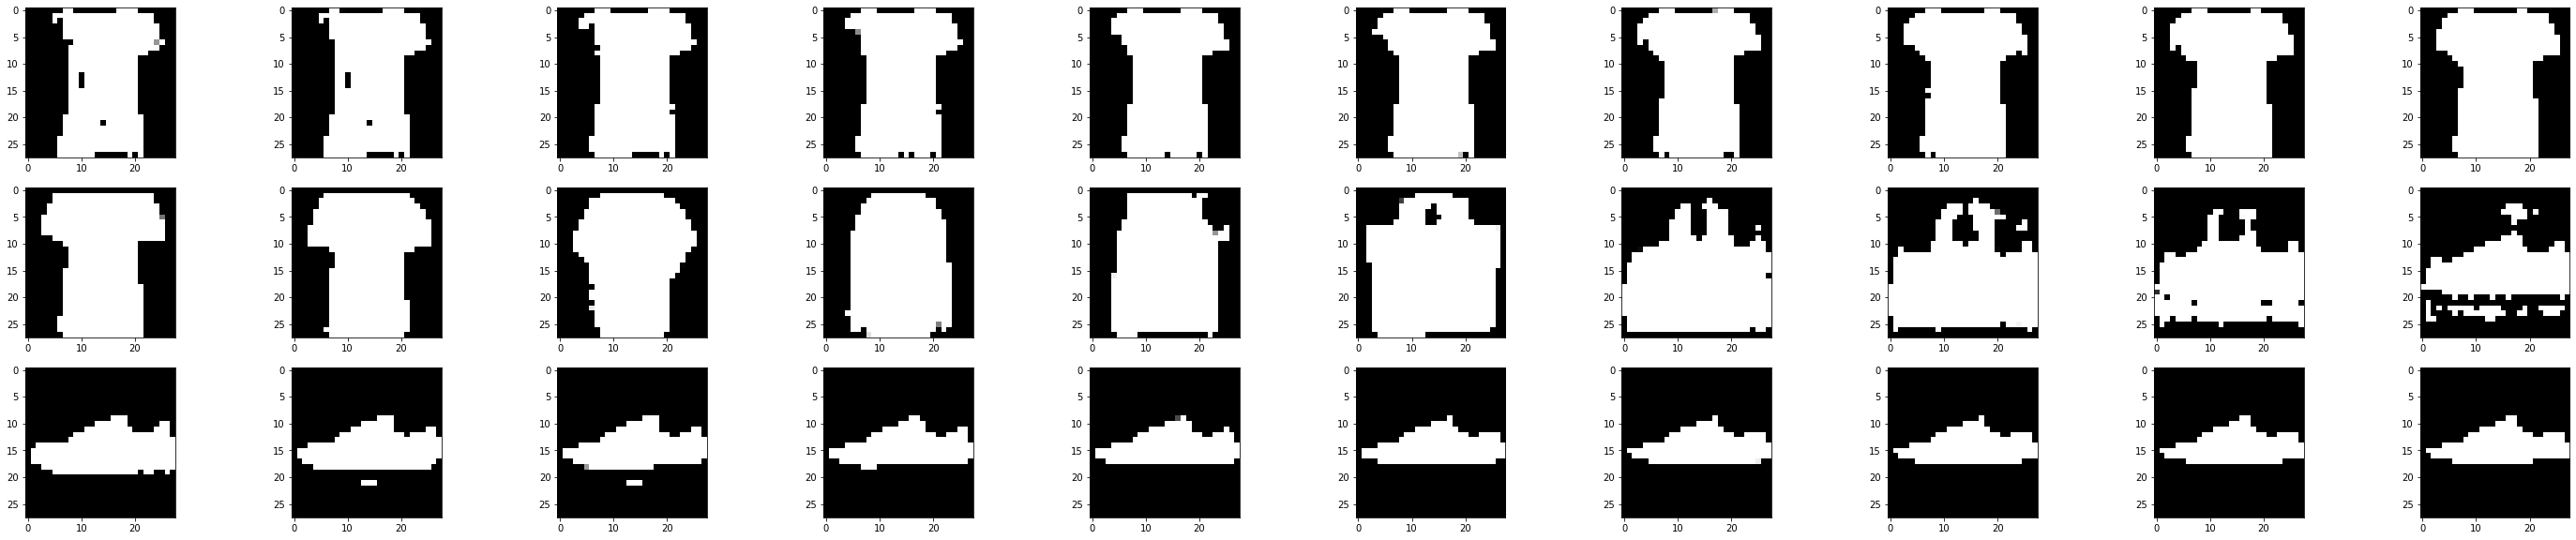

In [181]:
mask = np.array([1,1,1])
plt.figure(figsize=(50,10))
for i in range(30):
  tmp = rand_np + mask * (i - 15) * 500
  tensor = torch.from_numpy(tmp).float().to(device)
  # 得到encoded 测试集
  model.eval() # Set model to evaluation mode
  with torch.no_grad(): # Disable gradient calculation
      # Forward pass to get reconstructed output 
      img = model.decoder(tensor) 
      img_np = img.cpu().numpy()
  plt.subplot(3,10,i+1)
  plt.imshow(img_np.reshape(28,28), cmap='gray')
plt.show()